In [68]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as clr
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz
import random
import geopandas
import folium

# Load data

In [8]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case_encoded_iso_id.csv")
gcm_data = pd.read_pickle("../data/ortiz-bobea/data2/gcm_data.pkl")
data_len = len(data.fd_tmean)
test_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_test.csv")
train_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_train.csv")
ordered_country_list = list(dict.fromkeys(train_data.ISO3))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]

/tmp/ipykernel_162351/4115941307.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]


# Make dataset withholding random points

In [ ]:
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

In [ ]:
data_mod.to_csv("../data/ortiz-bobea/data2/regdata_train.csv")

In [ ]:
pd.DataFrame(withheld_rows).to_csv("../data/ortiz-bobea/data2/regdata_test.csv")

In [ ]:
pd.DataFrame(data).to_csv("../data/ortiz-bobea/data2/regdata_preferred_case_encoded_iso_id.csv")

# Estimate historical anthropogenic effect on TFP

In [3]:
# Green months
green_months = {}
green_month_data = pd.read_csv("../data/ortiz-bobea/data2/ndvi_co/peak_bottom_ndvi_month_country.csv")
for row in green_month_data.itertuples():
    peak = row[5]
    season = [i for i in range(peak-2,peak+3)]
    for i in range(len(season)):
        if season[i] < 1:
            season[i] = season[i] + 12
        elif season[i] > 12:
            season[i] = season[i] - 12
    green_months[row.ISO3] = season

In [6]:
## DO NOT RUN UNLESS GCM_DATA.PKL IS MISSING

gcms = ["BCC-CSM2-MR","CanESM5","CNRM-CM6-1","HadGEM3-GC31-LL","IPSL-CM6A-LR","MIROC6","MRI-ESM2-0"]
gcm_data = {gcm:{"hist_temp":{},"hist_prcp":{},"hist_nat_temp":{},"hist_nat_prcp":{}} for gcm in gcms}

for gcm in gcms:
    print(gcm)
    try:
        hist_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/historical_{gcm}_1948-2020_cropland.csv")
    except FileNotFoundError:
        hist_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/historical_{gcm}_1950-2020_cropland.csv")
    try:
        hist_nat_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/hist-nat_{gcm}_1948-2020_cropland.csv")
    except FileNotFoundError:
        hist_nat_data = pd.read_csv(f"../data/ortiz-bobea/data2/CMIP6_co/hist-nat_{gcm}_1950-2020_cropland.csv")

    hist_temp, hist_nat_temp, hist_prcp, hist_nat_prcp = {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}, {key:[] for key in list(set(data.ISO3))}
    
    for year in range(1961,2021):
        for country in set(data.ISO3):
    
            hist_rows = hist_data.loc[(hist_data["year"] == year) & (hist_data["ISO3"] == country)]
            hist_rows = [row for row in hist_rows.itertuples() if row.month in green_months[country]]
        
            nat_rows = hist_nat_data.loc[(hist_nat_data["year"] == year) & (hist_nat_data["ISO3"] == country)]
            nat_rows = [row for row in nat_rows.itertuples() if row.month in green_months[country]]
            
            hist_temp[country].append(np.mean([((row.tasmax + row.tasmin)/2)-273.15 for row in hist_rows]))
            hist_prcp[country].append(np.sum([row.pr for row in hist_rows]))
        
            hist_nat_temp[country].append(np.mean([((row.tasmax + row.tasmin)/2)-273.15 for row in nat_rows]))
            hist_nat_prcp[country].append(np.sum([row.pr for row in nat_rows]))

    gcm_data[gcm]["hist_temp"] = hist_temp
    gcm_data[gcm]["hist_prcp"] = hist_prcp
    gcm_data[gcm]["hist_nat_temp"] = hist_nat_temp
    gcm_data[gcm]["hist_nat_prcp"] = hist_nat_prcp

with open ("../data/ortiz-bobea/data2/gcm_data.pkl", 'wb') as buff:
    pkl.dump(gcm_data,buff)

BCC-CSM2-MR


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f22d8e0cee0>>
Traceback (most recent call last):
  File "/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



# Calculate impacts

In [4]:
# Revenue Weights
revenue_data = pd.read_csv("../data/ortiz-bobea/data/TFP_USDA/revenue_shares.csv")
country_weights = {}
for row in revenue_data.itertuples():
    if row[3] in set(data.ISO3):
        country_weights[row[3]] = np.mean([row[5],row[6],row[7],row[8],row[9],row[10]])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

In [5]:
# Historical climate means
country_climate_means = {}
country_1961_means = {}
ccm_file = pd.read_csv("../data/ortiz-bobea/data2/country_climate_means.csv")
for row in ccm_file.itertuples():
    country_climate_means[row[2]] = {"mean_temp":row[3], "mean_prcp":row[4]}
c1961_file = pd.read_csv("../data/ortiz-bobea/data2/country_climate_1961.csv")
for row in c1961_file.itertuples():
    country_1961_means[row[2]] = {"mean_temp":row[6],"mean_prcp":row[4]}

In [6]:
temp_hist_dev, temp_nat_dev, prcp_hist_dev, prcp_nat_dev = {}, {}, {}, {}
t1, t2, p1, p2 = {}, {}, {}, {}
t_diff, t_2_diff, p_diff, p_2_diff, = {}, {}, {}, {}

for gcm in gcm_data:
    
    temp_hist_dev[gcm] = {}
    temp_nat_dev[gcm] = {}
    prcp_hist_dev[gcm] = {}
    prcp_nat_dev[gcm] = {}
    t1[gcm] = {}
    t2[gcm] = {}
    p1[gcm] = {}
    p2[gcm] = {}
    t_diff[gcm] = {}
    p_diff[gcm] = {}
    t_2_diff[gcm] = {}
    p_2_diff[gcm] = {}
    
    for country in set(data.ISO3):
    
        temp_hist_dev[gcm][country] = np.array(gcm_data[gcm]["hist_temp"][country]) - country_climate_means[country]["mean_temp"]
        temp_nat_dev[gcm][country] = np.array(gcm_data[gcm]["hist_nat_temp"][country]) - country_climate_means[country]["mean_temp"]
        prcp_hist_dev[gcm][country] = 1 + (np.array(gcm_data[gcm]["hist_prcp"][country]) - country_climate_means[country]["mean_prcp"]) / country_climate_means[country]["mean_prcp"]
        prcp_nat_dev[gcm][country] = 1 + (np.array(gcm_data[gcm]["hist_nat_prcp"][country]) - country_climate_means[country]["mean_prcp"]) / country_climate_means[country]["mean_prcp"]
        
        t1[gcm][country] = temp_nat_dev[gcm][country] + country_1961_means[country]["mean_temp"]
        t2[gcm][country] = temp_hist_dev[gcm][country] + country_1961_means[country]["mean_temp"]
        p1[gcm][country] = prcp_nat_dev[gcm][country] * country_1961_means[country]["mean_prcp"]
        p2[gcm][country] = prcp_hist_dev[gcm][country] * country_1961_means[country]["mean_prcp"]
    
        t_diff[gcm][country] = t2[gcm][country] - t1[gcm][country]
        p_diff[gcm][country] = p2[gcm][country] - p1[gcm][country]
        t_2_diff[gcm][country] = pow(t2[gcm][country],2) - pow(t1[gcm][country],2)
        p_2_diff[gcm][country] = pow(p2[gcm][country],2) - pow(p1[gcm][country],2)

In [70]:
def sample_from_global_impacts(global_impacts, num_samples = 2000):
    random.seed(1)
    avg_res = []
    for i in range(num_predictions):
        samples = []
        gcm_sample = random.choices(list(gcm_data.keys()), k=num_samples)
        sample = random.choices(list(range(num_predictions)), k=num_samples)
        for i in range(num_samples):
            gcm = gcm_sample[i]
            samples.append((math.exp(global_impacts[gcm][sample[i]][-1])-1)*100)
        samples = sorted(samples)
        interval = np.quantile(samples,[.05,.95])
        avg_res.append([np.mean(samples),interval[0],interval[1]])
    print(np.mean(avg_res,axis=0))
    return samples, np.mean(avg_res,axis=0)

# Bayesian model

In [75]:
bayes_model_full = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed-hierarchical-std-error.pkl')
bayes_model_withheld = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')

In [76]:
random.seed(1)
indices = random.sample(range(4000),1000)

bayes_coef1_withheld = np.array([sample for index, sample in enumerate(list(bayes_model_withheld["trace"].posterior.fd_temp_tfp_coef.data.flatten())) if index in indices])
bayes_coef2_withheld = np.array([sample for index, sample in enumerate(list(bayes_model_withheld["trace"].posterior.fd_sq_temp_tfp_coef.data.flatten())) if index in indices])
bayes_coef3_withheld = np.array([sample for index, sample in enumerate(list(bayes_model_withheld["trace"].posterior.fd_precip_tfp_coef.data.flatten())) if index in indices])
bayes_coef4_withheld = np.array([sample for index, sample in enumerate(list(bayes_model_withheld["trace"].posterior.fd_sq_precip_tfp_coef.data.flatten())) if index in indices])
bayes_intercept_withheld = np.array([sample for index, sample in enumerate(bayes_model_withheld["trace"].posterior.tfp_intercept.data.flatten()) if index in indices])
bayes_country_coefs_withheld = np.transpose([sample for index,sample in enumerate(np.vstack(bayes_model_withheld["trace"].posterior.country_coefs.data)) if index in indices])
bayes_year_coefs_withheld = np.transpose([sample for index,sample in enumerate(np.vstack(bayes_model_withheld["trace"].posterior.year_coefs.data)) if index in indices])

bayes_coef1_full = np.array([sample for index, sample in enumerate(list(bayes_model_full["trace"].posterior.fd_temp_tfp_coef.data.flatten())) if index in indices])
bayes_coef2_full = np.array([sample for index, sample in enumerate(list(bayes_model_full["trace"].posterior.fd_sq_temp_tfp_coef.data.flatten())) if index in indices])
bayes_coef3_full = np.array([sample for index, sample in enumerate(list(bayes_model_full["trace"].posterior.fd_precip_tfp_coef.data.flatten())) if index in indices])
bayes_coef4_full = np.array([sample for index, sample in enumerate(list(bayes_model_full["trace"].posterior.fd_sq_precip_tfp_coef.data.flatten())) if index in indices])
bayes_intercept_full = np.array([sample for index, sample in enumerate(bayes_model_full["trace"].posterior.tfp_intercept.data.flatten()) if index in indices])
bayes_country_coefs_full = np.transpose([sample for index,sample in enumerate(np.vstack(bayes_model_full["trace"].posterior.country_coefs.data)) if index in indices])
bayes_year_coefs_full = np.transpose([sample for index,sample in enumerate(np.vstack(bayes_model_full["trace"].posterior.year_coefs.data)) if index in indices])

In [73]:
num_predictions = len(bayes_coef1_full)
bayes_cumulative_gcm_global_impacts = {}
for gcm in gcm_data.keys():
    bayes_cumulative_gcm_global_impacts[gcm] = []
    country_res = {}
    for country in set(data.ISO3):
        country_res[country] = []
        for i in range(num_predictions):
            country_res[country].append(
                t_diff[gcm][country]*bayes_coef1_full[i] + 
                t_2_diff[gcm][country]*bayes_coef2_full[i] + 
                p_diff[gcm][country]*bayes_coef3_full[i] + 
                p_2_diff[gcm][country]*bayes_coef4_full[i]
        )
    for coef in range(num_predictions):
        coef_vals = []
        for year in range(0,60):
            year_vals = []
            for country, values in country_res.items():
                year_vals.append(values[coef][year] * country_weights[country])
            coef_vals.append(np.sum(year_vals))
        bayes_cumulative_gcm_global_impacts[gcm].append(np.cumsum(coef_vals))

bayes_gcm_averages = {gcm:(math.exp(np.mean([elem[-1] for elem in bayes_cumulative_gcm_global_impacts[gcm]]))-1)*100 for gcm in gcm_data}
bayes_res, bayes_interval = sample_from_global_impacts(bayes_cumulative_gcm_global_impacts)

[-20.67088321 -38.97625332 -10.25643602]


In [78]:
bayes_yhat = []
bayes_real_y = []
min_year = min(train_data.year)
for row in test_data.sort_values(by="fd_log_tfp").iterrows():
# for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    bayes_real_y.append(row[1].fd_log_tfp)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = bayes_country_coefs_withheld[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = bayes_year_coefs_withheld[year - min_year -1]
    predict_tfp = (
        temp*bayes_coef1_withheld + 
        temp2*bayes_coef2_withheld +
        precip*bayes_coef3_withheld +
        precip2*bayes_coef4_withheld +
        country_effect +
        year_effect +
        bayes_intercept_withheld
    )
    bayes_yhat.append(sorted(predict_tfp))

In [79]:
in_range, out_range = 0, 0
bayes_lowers, bayes_uppers = [], []
for index, prediction in enumerate(bayes_yhat):
    interval = np.quantile(prediction,[.025,.975])
    bayes_lowers.append(interval[0])
    bayes_uppers.append(interval[1])
    if bayes_real_y[index] >= interval[0] and bayes_real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(bayes_yhat))
print(out_range/len(bayes_yhat))

0.38271604938271603
0.6172839506172839


# Bootstrap from Stata

In [ ]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_withheld.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
    elif "_b" in column:
        if "cons" in column:
            column_names[index] = "intercept"
        else:
            column_names[index] = column.replace("_b[","").replace("]","")
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_withheld_better_column_names.csv")

In [80]:
full_bootstrap = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_better_column_names.csv", header=1)
withheld_bootstrap = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_withheld_better_column_names.csv", header=1)

missing_indices = []
for index, row in enumerate(full_bootstrap.itertuples()):
    if np.isnan(row.fd_tmean):
        missing_indices.append(index)
full_bootstrap = full_bootstrap.drop(missing_indices).reset_index(drop=True)[:1000]

missing_indices = []
for index, row in enumerate(withheld_bootstrap.itertuples()):
    if np.isnan(row.fd_tmean):
        missing_indices.append(index)
withheld_bootstrap = withheld_bootstrap.drop(missing_indices).reset_index(drop=True)[:1000]

In [81]:
boot_coef1_full = full_bootstrap["fd_tmean"]
boot_coef2_full = full_bootstrap["fd_tmean_sq"]
boot_coef3_full = full_bootstrap["fd_prcp"]
boot_coef4_full = full_bootstrap["fd_prcp_sq"]

boot_coef1_withheld = withheld_bootstrap["fd_tmean"]
boot_coef2_withheld = withheld_bootstrap["fd_tmean_sq"]
boot_coef3_withheld = withheld_bootstrap["fd_prcp"]
boot_coef4_withheld = withheld_bootstrap["fd_prcp_sq"]

In [54]:
num_predictions = len(boot_coef1_full)

boot_cumulative_gcm_global_impacts = {}
for gcm in gcm_data.keys():
    boot_cumulative_gcm_global_impacts[gcm] = []
    country_res = {}
    for country in set(data.ISO3):
        country_res[country] = []
        for i in range(num_predictions):
            country_res[country].append(
                t_diff[gcm][country]*boot_coef1_full[i] + 
                t_2_diff[gcm][country]*boot_coef2_full[i] + 
                p_diff[gcm][country]*boot_coef3_full[i] + 
                p_2_diff[gcm][country]*boot_coef4_full[i]
        )
    for coef in range(num_predictions):
        coef_vals = []
        for year in range(0,60):
            year_vals = []
            for country, values in country_res.items():
                year_vals.append(values[coef][year] * country_weights[country])
            coef_vals.append(np.sum(year_vals))
        boot_cumulative_gcm_global_impacts[gcm].append(np.cumsum(coef_vals))

boot_gcm_averages = {gcm:(math.exp(np.mean([elem[-1] for elem in boot_cumulative_gcm_global_impacts[gcm]]))-1)*100 for gcm in gcm_data}
boot_res, boot_interval = sample_from_global_impacts(boot_cumulative_gcm_global_impacts)

[-20.63871194 -40.55396941  -9.83607034]


In [82]:
boot_yhat = []
boot_real_y = []
for row in test_data.sort_values(by="fd_log_tfp").iterrows():
# for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    boot_real_y.append(row[1].fd_log_tfp)
    predict_tfp = (
        temp*boot_coef1_withheld + 
        temp2*boot_coef2_withheld +
        precip*boot_coef3_withheld +
        precip2*boot_coef4_withheld +
        withheld_bootstrap[country] +
        withheld_bootstrap[str(year)] +
        withheld_bootstrap["intercept"]
    )
    boot_yhat.append(sorted(predict_tfp))

In [83]:
in_range, out_range = 0, 0
boot_lowers, boot_uppers = [], []
for index, prediction in enumerate(boot_yhat):
    interval = np.quantile(prediction,[.025,.975])
    boot_lowers.append(interval[0])
    boot_uppers.append(interval[1])
    if boot_real_y[index] >= interval[0] and boot_real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(boot_yhat))
print(out_range/len(boot_yhat))

0.36419753086419754
0.6358024691358025


# Delta Method

In [60]:
diff_data = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_diff_pred.csv")
num_predictions = 1000
gcm_global_impacts = {}

for row in diff_data.iterrows():
    row = row[1]
    gcm = row.gcm
    year = row.year
    country = row.iso3
    pred = row.yhat
    err = row.stdp
    if gcm not in gcm_global_impacts:
        gcm_global_impacts[gcm] = {}
    if year not in gcm_global_impacts[gcm]:
        gcm_global_impacts[gcm][year] = []
    gcm_global_impacts[gcm][year].append([sample*country_weights[country] for sample in np.random.normal(pred,err,num_predictions)])

delta_cumulative_gcm_global_impacts = {}
for gcm in gcm_data.keys():
    year_vals = []
    for year, country_samples in gcm_global_impacts[gcm].items():
        year_vals.append(np.sum(country_samples,axis=0))
    delta_cumulative_gcm_global_impacts[gcm] = np.transpose(np.cumsum(year_vals,axis=0))

delta_gcm_averages = {gcm:(math.exp(np.mean(delta_cumulative_gcm_global_impacts[gcm][:,-1]))-1)*100 for gcm in gcm_data}
delta_sim_res, delta_interval = sample_from_global_impacts(delta_cumulative_gcm_global_impacts)

[-20.71753511 -36.67093536  -9.84569543]


In [84]:
in_range = 0
out_range = 0
delta_lowers, delta_uppers = [], []
delta_real_y = []

delta_yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred_outsample.csv")
# delta_yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred_insample.csv")
for row in enumerate(delta_yhat.sort_values(by="fd_log_tfp").itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    delta_real_y.append(row[1].fd_log_tfp)
    if lower <= delta_real_y[-1] and upper >= delta_real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    delta_lowers.append(lower), delta_uppers.append(upper)

print(in_range / len(delta_yhat))
print(out_range / len(delta_yhat))

0.38271604938271603
0.6172839506172839


# Make Figure

In [48]:
colors = {"Bayes":"orange","Bootstrap":"green","Delta":"purple"}

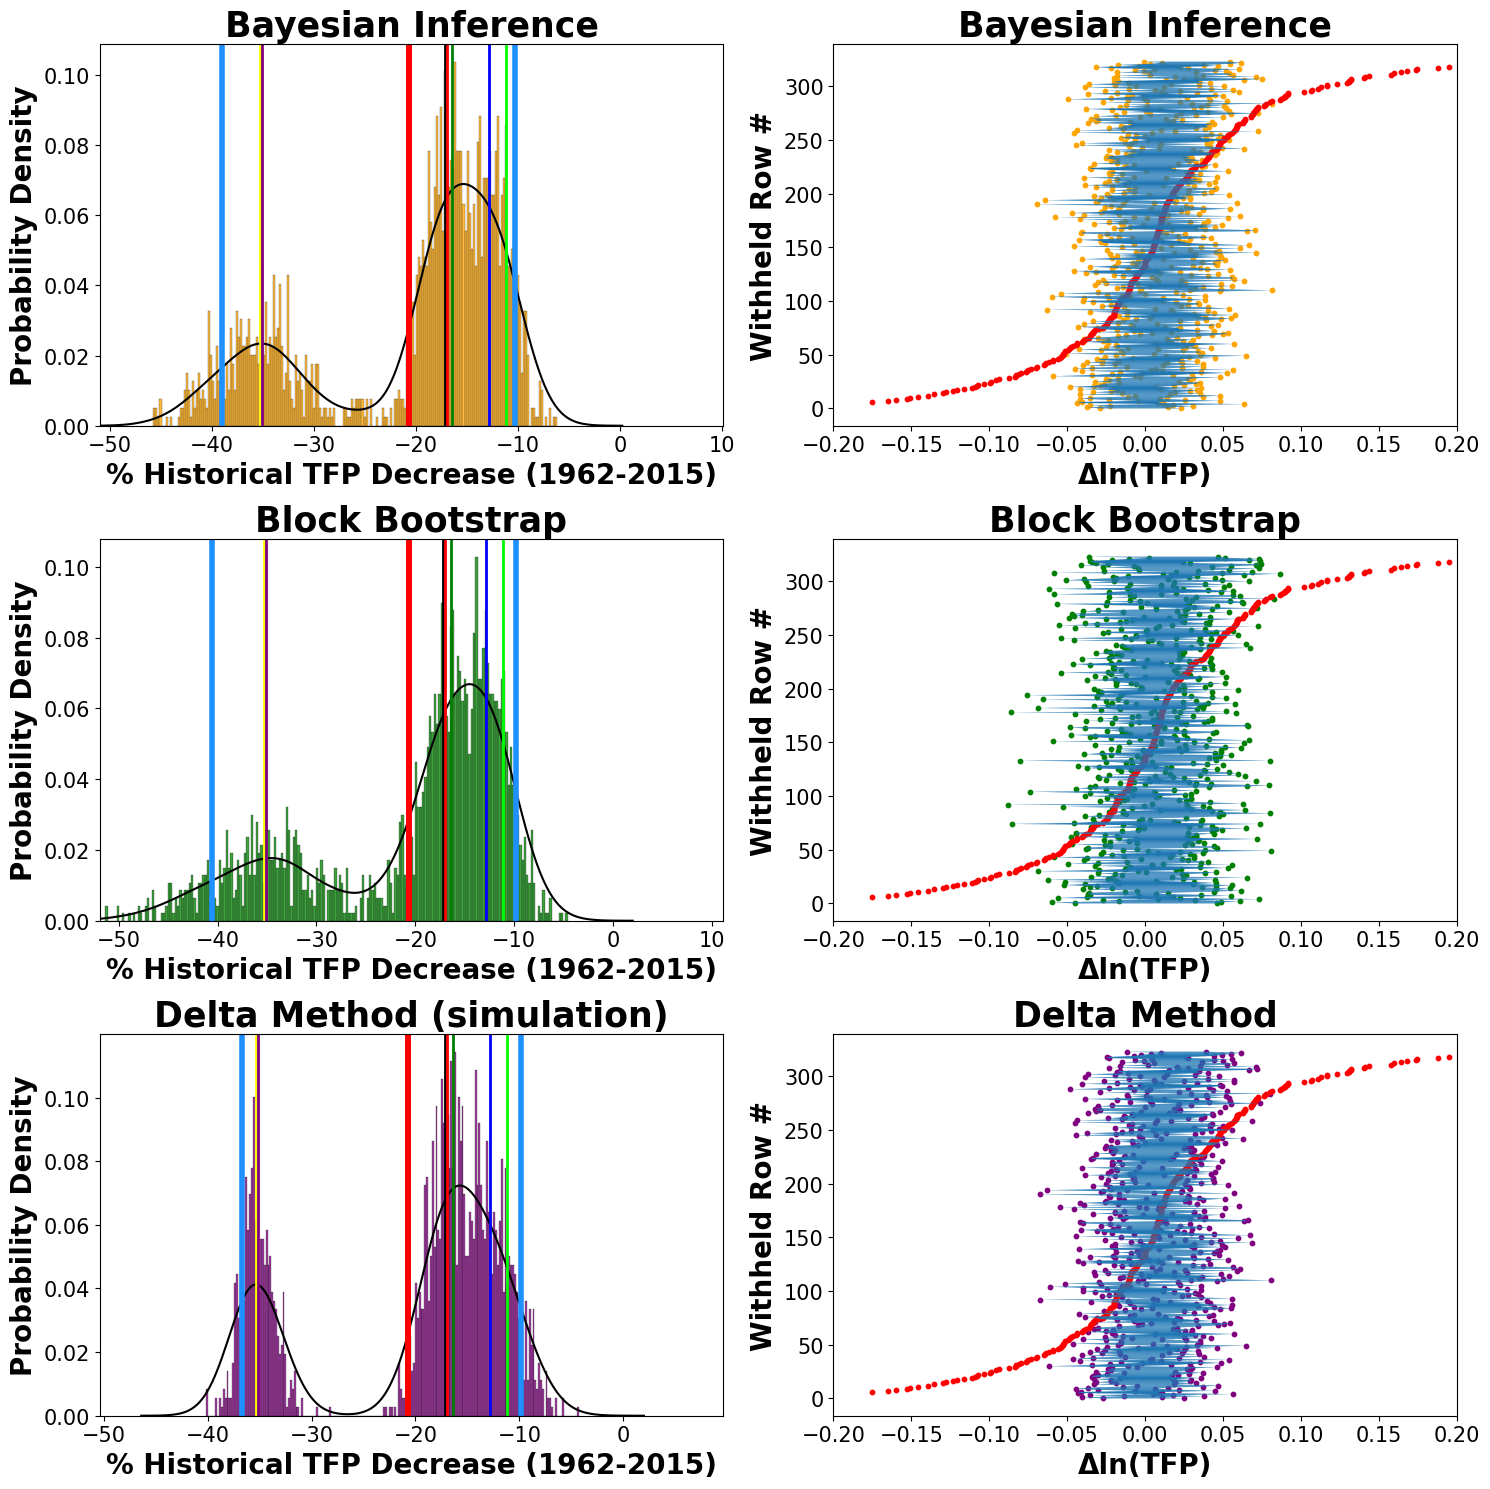

In [85]:
gcm_line_colors = ["black","yellow","red","green","purple","lime","blue"]

def make_hist_plot(axis, data, interval, color, labels):
    x = np.linspace(np.mean(data) - 3*np.std(data), np.mean(data) + 3*np.std(data), 100)
    sns.histplot(data,bins=200,color=color,stat="density", ax=axis)
    sns.kdeplot(data, ax=axis, color="black")
    axis.set_xlim(min(x)-1.5, max(x)+1.5)
    axis.xaxis.label.set_size(20)
    axis.yaxis.label.set_size(20)
    axis.xaxis.set_tick_params(labelsize=15)
    axis.yaxis.set_tick_params(labelsize=15)
    for index, (gcm, gcm_average) in enumerate(bayes_gcm_averages.items()):
        color = gcm_line_colors[index]
        axis.axvline(x = gcm_average, color = color, lw=2, label = gcm)
        axis.axvline(x = interval[0], color = 'r', lw = 4, label = labels[0])
    axis.axvline(x = interval[1], color = 'dodgerblue', lw = 4, label = labels[1])
    axis.axvline(x = interval[2], color = 'dodgerblue', lw = 4, label = labels[2])
    axis.set_xlabel("% Historical TFP Decrease (1962-2015)", weight="bold")
    axis.set_ylabel("Probability Density", weight="bold")
    axis.set_title(labels[3], weight="bold")
    axis.title.set_size(25)

def make_pred_int_plots(axis, lowers, uppers, real_y, color, label):
    axis.scatter(lowers, list(range(len(lowers))), color=color, s=10)
    axis.scatter(uppers, list(range(len(lowers))), color=color, s=10)
    axis.scatter(real_y, list(range(len(lowers))), color="red", s=10)
    last_line = None
    for index in range(len(lowers)):
        if last_line != None:
            axis.add_patch(
                patches.Polygon(
                    xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
                )
            )
        last_line = [lowers[index],uppers[index]]
    axis.set_xlabel("Δln(TFP)", weight="bold")
    axis.set_ylabel("Withheld Row #", weight="bold")
    axis.xaxis.label.set_size(20)
    axis.yaxis.label.set_size(20)
    axis.xaxis.set_tick_params(labelsize=15)
    axis.yaxis.set_tick_params(labelsize=15)
    axis.set_title(label, weight="bold")
    axis.title.set_size(25)
    axis.set_xlim(-.2, .2)

fig, axes = plt.subplots(3,2, figsize=(15,15))

make_hist_plot(axes[0][0], bayes_samples, bayes_interval, colors["Bayes"],
    labels=[
    'Bayesian Inference Vertex Mean', 'Bayesian Inference Vertex Lower Bound',
    'Bayesian Inference Vertex Upper Bound','Bayesian Inference'
])
make_hist_plot(axes[1][0], boot_res, boot_interval, colors["Bootstrap"],
    labels=[
    'Block Bootstrap Vertex Mean', 'Block Bootstrap Vertex Lower Bound',
    'Block Bootstrap Vertex Upper Bound', 'Block Bootstrap'
])
make_hist_plot(axes[2][0], delta_sim_res, delta_interval, colors["Delta"],
    labels=[
    'Delta Method Vertex Mean', 'Delta Method Vertex Lower Bound',
    'Delta Method Vertex Upper Bound', 'Delta Method (simulation)'
])

make_pred_int_plots(axes[0][1], bayes_lowers, bayes_uppers, bayes_real_y, colors["Bayes"], "Bayesian Inference")
make_pred_int_plots(axes[1][1], boot_lowers, boot_uppers, boot_real_y, colors["Bootstrap"], "Block Bootstrap")
make_pred_int_plots(axes[2][1], delta_lowers, delta_uppers, delta_real_y, colors["Delta"], "Delta Method")

fig.tight_layout()

# plt.show()
# plt.savefig("../figures/fig1_working.png", bbox_inches='tight')
# plt.savefig("../figures/fig1_no_labels.eps", bbox_inches='tight', format="eps", dpi=1000)